<a href="https://colab.research.google.com/github/yebiFesseha/hello-world/blob/master/Machine_Learning_movies_Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Basics
## Box Office Data

Today, we will be exploring fundamental concepts of machine learning.

__Question:__ How much gross revenue will a new movie make?

__Data Set:__ Information from past movies and their gross revenue, including:
- Actor and director information
- Movie length 
- Budget

__Goal:__ Use the data from the past to build a predictive model to help us predict how much revenue a movie will make


You will need to add some code to complete this notebook.  Follow along with the instructor to find what code to add.  You will add that where the code says "\*\*\* ADD CODE HERE\*\*\*"

Have fun and good luck coding!

## Importing the packages that we'll need

One of the things that makes Python **great** for data science is all of the different libraries that exist so we don't have to code them from scratch. Tonight we'll be taking advantage of:
- [Numpy](https://numpy.org/) for scientific and mathematical computing
- [Pandas](https://pandas.pydata.org/) for data wrangling and analysis

In [1]:
# data analysis packages
import numpy as np
import pandas as pd

# plotting package
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import the data
Pandas can work with information from all kinds of data sources. Below, we'll import the data we need from a GitHub URL and read it into a Pandas Dataframe using the Pandas [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

In [ ]:
# import data from github
data = pd.read_csv("https://github.com/autumntoney/predict_the_box_office/raw/master/movie_metadata.csv")

## Data Cleaning and Feature Engineering

The data we just imported is not ready for modeling, so we will clean the data by removing duplicates and imputing or dropping missing values.  

Then, using the cleaned data, we will engineer some features to hopefully improve our predictions.

*Note: We won't get into this code in depth, but we wanted to provide the original data so you can go back to it if you wanted to clean it and/or engineer more features.* 

In [ ]:
# DATA CLEANING
# Rename columns to include units
data.rename(columns={'duration': 'duration_mins',
                    'budget': 'budget_usd',
                    'gross': 'gross_usd'}, inplace=True)

# Drop all duplicate movie titles that were released in the same year
data = data.drop_duplicates(subset=['movie_title', 'title_year'], keep='first').copy()

# Drop the aspect ratio column,  axis=1 means drop the column
data.drop('aspect_ratio', axis=1, inplace=True)

# Drop all null values of gross
# You will be predicting this value
# so don't want to impute these values (skew the analysis)
data.dropna(subset=['gross_usd'], how='all', inplace=True)

# Drop movies where the year is missing
data.dropna(subset=['title_year'], how='all', inplace=True)
# Convert all years to integers
data['title_year'] = data['title_year'].astype(int)

# Calculate median budgets per year
# Impute the median budgets per year for missing budget data
data['budget_usd'] = data['budget_usd'].fillna(data.groupby('title_year')['budget_usd'].transform('median'))

# Drop the remaining row that is missing budget
# (no other movies from 1942 in the dataset)
data.dropna(subset=['budget_usd'], axis=0, inplace=True)

# Find how many movies are in each country in the data
counts = data['country'].value_counts()
# Select the data from only the top 3 countries
data = data[data['country'].isin(counts.nlargest(3).index)].copy()

# Dropping all remaining rows that have null values
data.dropna(axis=0, inplace=True)

# FEATURE ENGINEERING
# Identify all movie counts, select all star actors
lead_movie_counts = data['actor_1_name'].value_counts()
star_actors = lead_movie_counts[lead_movie_counts >= 20].index
# Set `lead_star` = 1 if actor is in star_actors, otherwise 0
data['lead_star'] = [1 if x in star_actors else 0 for x in data['actor_1_name']]

# Encoding ratings as dummy variables
content_ratings = pd.get_dummies(data['content_rating'])
# Merge the encoded data back on to the original data
data = data.join(content_ratings)

# Select columns by data type - number
numerical_data = data.select_dtypes(include='number')
numerical_data.head()

,num_critic_for_reviews,duration_mins,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross_usd,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget_usd,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,lead_star,Approved,G,GP,M,NC-17,Not Rated,PG,PG-13,Passed,R,Unrated,X
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,886204,4834,0.0,3054.0,237000000.0,2009,936.0,7.9,33000,0,0,0,0,0,0,0,0,1,0,0,0,0
1,302.0,169.0,563.0,1000.0,40000.0,309404152.0,471220,48350,0.0,1238.0,300000000.0,2007,5000.0,7.1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,602.0,148.0,0.0,161.0,11000.0,200074175.0,275868,11700,1.0,994.0,245000000.0,2015,393.0,6.8,85000,0,0,0,0,0,0,0,0,1,0,0,0,0
3,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,1144337,106759,0.0,2701.0,250000000.0,2012,23000.0,8.5,164000,0,0,0,0,0,0,0,0,1,0,0,0,0
5,462.0,132.0,475.0,530.0,640.0,73058679.0,212204,1873,1.0,738.0,263700000.0,2012,632.0,6.6,24000,0,0,0,0,0,0,0,0,1,0,0,0,0


## Selecting Features and Output
We're just about ready for the machine learning phase of our project, but first we'll want to identify 2 different things:
1. **Feature matrix**: this is the group of columns (features/variables/attributes) that will be used to determine our outcome.
2. **Target array**: this is the series (target/label/outcome) that contains the information that we're ultimately trying to predict.

So in this case, we're using the numerical data columns to predict the `gross_usd` revenue of the movies!

In [ ]:
# Identifying our Feature set (X) and target (y) variables for modeling
X = numerical_data.drop(['gross_usd'], axis=1)
y = numerical_data['gross_usd']

Now that we have our data cleaned and features engineered, the final step before we can model is splitting the data into training sets and testing sets so we can evaluate the models.  We'll use the sklearn [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to do this, keeping 20% of the data in the test set, so we can train the model with 80% of the data. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Machine Learning Steps
We always do 4 things when modeling:
1. Instantiate the model (start it up)
2. Fit the model using the `.fit()` function
3. Make predictions using the `.predict()` function
4. Evaluate the model using our chosen evaluation metrics

We will do all of these steps for each model we've chosen to use today, linear regression, decision tree, and random forest.

## Linear Regression

A [linear regression](https://www.youtube.com/user/joshstarmer/search?query=linear+regression) model finds the line of best fit for the data.  

This line of best fit has an equation similar to `y = mx+b`.  
The line found by the model has a pre-determined `m` (slope), and `b` (intercept), so when you have a new input (`x`), your `y` is your prediction.

Note that in this example, there is only one feature (`x`), but most models will use more features and therefore have more terms in the equation.

[Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) models are good for simple data sets and where a linear relationship exists.


*Note: Detail on [how much math is needed for Data Science](https://www.thinkful.com/blog/math-needed-for-data-science/)*


<div>
<img src="https://mlfromscratch.com/content/images/2020/01/linearRegression2-3.png" width="500"/>
</div>

In [ ]:
from sklearn.linear_model import LinearRegression

# Step 1: Instantiating the model
lr = LinearRegression()

# Step 2: Fit the model (note, we use the train set here)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now that we've trained the model, we can make predictions.  We will predict the `y`-values of the test set using the `.predict()` function and plot the predictions against the actuals to determine how well the model predicted the gross revenue of the movie.  

Note: If the model was perfect at predicting the gross revenue of movies, the points would follow the red line (`y=x`)

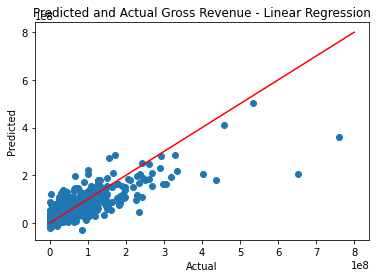

In [ ]:
# Step 3: Make predictions (note, we use the test set here)
y_pred_lr = lr.predict(X_test)

# Plot predicted values versus actual values
plt.scatter(y_test, y_pred_lr)
plt.plot([0,8e8], [0,8e8], linestyle='-', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted and Actual Gross Revenue - Linear Regression');

We can see that the model did an okay job of predicting the gross revenues of movies that had a lower revenue, but it wasn't able to predict the output of the higher grossing movies.

Let's evaluate our model using both R-squared ($R^2$) and [`Root`](https://numpy.org/doc/1.18/reference/generated/numpy.sqrt.html) [`Mean Squared Error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (RMSE).  As a reminder, models that can explain more variance in the data have $R^2$ values closer to 1, and lower RMSE means that the data is concentrated more closely around the line of best fit.

In [ ]:
# Step 4: Evaluate the model (note, we use the test set here)
print('Evaluating the Linear Regression Model')
lr_r2 = lr.score(X_test, y_test)
print('R Squared: \t\t\t', lr_r2)

lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print('Root Mean Squared Error: \t', lr_rmse)


Evaluating the Linear Regression Model
R Squared: 			 0.646624714708111
Root Mean Squared Error: 	 44495480.23955882


Great - we'll compare these evaluation metrics to the other models we are going to try. 

To help us understand how the model is making predictions, we can check out the Linear Regression's intercept and coefficients.

In [ ]:
# Interpreting how the model is making predictions
# Linear regression models give the coefficients (m), and intercept (b)
coefs = pd.DataFrame(zip(X.columns, lr.coef_), 
                     columns=['Feature Names', 'Coefficients'])
print('Intercept: ', lr.intercept_)
coefs.sort_values('Coefficients', ascending=False)

Intercept:  1493305776.6120522


,Feature Names,Coefficients
16,G,3.425091e+07
21,PG,2.620286e+07
18,M,1.531109e+07
22,PG-13,1.185229e+07
14,lead_star,4.444894e+06
17,GP,4.281497e+06
15,Approved,6.817379e+05
12,imdb_score,4.639117e+05
0,num_critic_for_reviews,5.402148e+04
6,cast_total_facebook_likes,7.081828e+03


So what does this mean?

The `intercept` is the gross revenue of a movie before you take into account any of the features of the movie.  Then each `coefficient` represents the amount of change in the gross revenue for each feature.  

Linear Regression models are great for being able to explain exactly how the model made its predictions. 

## Decision Tree
Decision Trees in classification problems are like flow charts where the model takes the data from the past to figure out the best split points to predict what category the data is in.  

In regression, the model does the same, but instead of predicting the category, the numerical values at the end of the flow chart (leaves) are averaged to determine the predicted value.  

In the example below, the `Windy = FALSE` number of hours played are all averaged to get the prediction value of 47.7 hours.
And the `Windy = TRUE` hours played are averaged to get the prediction value of 26.5 hours.

[Decision trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) are good for non-linear relationships, but can be prone to overfitting (the model predicts too closely to the training set).


<div>
<img src="https://www.saedsayad.com/images/Decision_tree_r8.png" width="700"/>
</div>

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Step 1: Instantiating the model
dt = DecisionTreeRegressor(random_state=42)

# Step 2: Fit the model (note, we use the train set here)
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

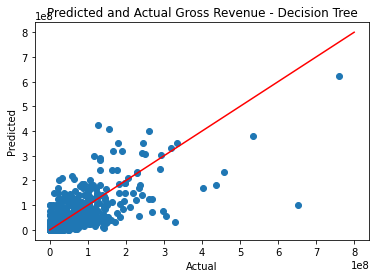

In [ ]:
# Step 3: Make predictions (note, we use the test set here)
y_pred_dt = dt.predict(X_test)

# Plot predicted values versus actual values
plt.scatter(y_test, y_pred_dt)
plt.plot([0,8e8], [0,8e8], linestyle='-', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted and Actual Gross Revenue - Decision Tree');

Visually, this model was a little better at predicting the higher grossing movies than the linear regression model, but is worse at predicting the lower grossing movies.  Let's check out the evaluation metrics.

In [ ]:
# Step 4: Evaluate the model (note, we use the test set here)
print('Evaluating the Decision Tree Model')
dt_r2 = dt.score(X_test, y_test)
print('R Squared: \t\t\t', dt_r2)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print('Root Mean Squared Error: \t', dt_rmse)


Evaluating the Decision Tree Model
R Squared: 			 0.39720785586230845
Root Mean Squared Error: 	 58114111.76458808


This Decision Tree has a lower $R^2$ and a higher RMSE than the linear regression, so our visual representation of the predictions matches with the evaluation metrics.

Now for tree-based models, there aren't coefficients to explain the predictions, but they **do** have feature importances, which represent how much each feature (column/variable) impacts the predition.  Feature importances are values between 0 and 1, with higher values representing features that are more valuable in making predictions.  However, this does NOT represent if the feature is important in increasing or decreasing the predicted value.

In [ ]:
# Interpreting how the model is making predictions
# Decision trees calculate the importance of features 
#(doesn't speak to directionality)
import_dt = pd.DataFrame(zip(X.columns, dt.feature_importances_, ),
                         columns=['Feature Names', 'Feature Importances'])
import_dt.sort_values('Feature Importances', ascending=False)

,Feature Names,Feature Importances
5,num_voted_users,4.853524e-01
9,budget_usd,1.794965e-01
0,num_critic_for_reviews,3.243242e-02
12,imdb_score,3.157500e-02
21,PG,3.149019e-02
8,num_user_for_reviews,3.138577e-02
10,title_year,2.896788e-02
6,cast_total_facebook_likes,2.692085e-02
1,duration_mins,2.684478e-02
4,actor_1_facebook_likes,2.309274e-02


This means that for this Decision Tree model the feature `num_voted_users` is the most important in predicting `gross_usd` revenue. And all of the features that have feature importances of 0 are not used to generate predictions for this model.

## Random Forest

A Random Forest model takes the great parts of the Decision Tree, and removes a lot of the risk of overfitting.  

The model creates a bunch of Decision Tree predictions, and the resulting prediction is the average of all of the predictions for regression and the most often (mode) predictions for classification.  

[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) models are good for complex datasets and when you have a large amount of data.

<div>
<img src="https://miro.medium.com/max/2612/0*f_qQPFpdofWGLQqc.png" width="500"/>
</div>

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Instantiating the model
rf = RandomForestRegressor(random_state=42) ####### This line is for Audience participation # ***INSTANTIATE MODEL HERE***

# Step 2: Fit the model (note, we use the train set here)
rf.fit(X_train, y_train) ####### This line is for Audience participation # ***FIT MODEL ON TRAINING DATA HERE***

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

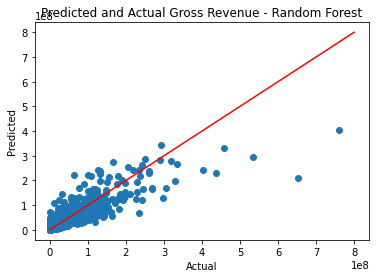

In [ ]:
# Step 3: Make predictions (note, we use the test set here)
y_pred_rf = rf.predict(X_test) ####### This line is for Audience participation # ***PREDICT VALUES ON TEST DATA HERE***

# Plot predicted values versus actual values
plt.scatter(y_test, y_pred_rf)
plt.plot([0,8e8], [0,8e8], linestyle='-', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted and Actual Gross Revenue - Random Forest');

Again, the Random Forest model isn't good at predicting the higher grossing movies, but is fairly good at predicting the lower grossing movies.  Visually, it's hard to tell the difference between how the Random Forest and the Linear Regression model predicted `gross_usd`.

In [ ]:
# Step 4: Evaluate the model (note, we use the test set here)
print('Evaluating the Random Forest Model')
rf_r2 = dt.score(X_test, y_test)
print('R Squared: \t\t\t', rf_r2)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error: \t', rf_rmse)

Evaluating the Random Forest Model
R Squared: 			 0.39720785586230845
Root Mean Squared Error: 	 42323099.09456607


This has a similar $R^2$ value as the Decision Tree, but a much lower RMSE. More on that in a minute.

Random Forests are also tree-based, so use the same feature importances as Decision Trees to explain how they make predictions.

In [ ]:
# Interpreting how the model is making predictions
# Decision trees calculate the importance of features 
#(doesn't speak to directionality)
import_rf = pd.DataFrame(zip(X.columns, rf.feature_importances_), ####### This line is for Audience participation # ***CALCULATE FEATURE IMPORTANCES HERE***
                         columns=['Feature Names', 'Feature Importances'])
import_rf.sort_values('Feature Importances', ascending=False)


,Feature Names,Feature Importances
5,num_voted_users,4.589050e-01
9,budget_usd,2.071092e-01
10,title_year,3.558404e-02
8,num_user_for_reviews,3.288922e-02
1,duration_mins,3.148756e-02
24,R,2.905913e-02
0,num_critic_for_reviews,2.761696e-02
12,imdb_score,2.588842e-02
6,cast_total_facebook_likes,2.153259e-02
13,movie_facebook_likes,2.063400e-02


Again, the `num_voted_users` feature is the most important in making predictions.  Note that the features that previously had feature importances of 0 are now no-zero because multiple Decision Trees are used in creating the Random Forest, so some trees might have used those features.

## Comparing the Models

Now that we've trained three different models, let's compare their predictive ability so we can decide which model to use to make our predictions.

In [ ]:
# Setting up our evaluation metrics so we can compare
r2s = [lr_r2, dt_r2, rf_r2]
rmses = [lr_rmse, dt_rmse, rf_rmse]
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest']
# Putting all of the metrics together
comparison = pd.DataFrame(zip(model_names, r2s, rmses),
                           columns=['Model', 'R-squared Score', 'RMSE'])
comparison

,Model,R-squared Score,RMSE
0,Linear Regression,0.646625,4.449548e+07
1,Decision Tree,0.397208,5.811411e+07
2,Random Forest,0.397208,4.232310e+07


The Linear Regression model has the highest $R^2$ score, but the Random Forest model has the lowest RMSE.  

**You be the judge:** Which model would you suggest to your boss that we should use to help make predictions about the gross revenue of a film? Why?

# Take Home Challenge
- Drop the features that you can only determine AFTER the movie premiers, and see how that impacts your model's predictions
- Try out different models for predicting the gross revenue of a movie 
  - Try [learning about kNN Regression](https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/) (predictions are the average of the neighbors), and seeing how [kNN Regression](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) works for this dataset. 
- Investigate outliers and clean or drop them and see how they impact the model predictions
- Analyze your clean data (see Thinkful's Art of Visualization workshops/webinars for additional support)
  - Drop features that are not related to `gross_usd` and see how it changes the model performance
- Go back and impute some of the missing data that we dropped and see how that impacts the models
- Continue to engineer features based on what you know about the subject and see how it impacts the models
  - Maybe the era of the film might have something to do with the gross revenue.  The [history of film](http://www.historyoffilm.net/movie-eras/history-of-cinema/) documents the movie eras we can use to create our new feature along with Pandas [`.cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) function.
  - Here is some starter code to get the ball rolling:
  - Identify the era of the film

    era_bins = [0, 1910, 1926, 1940, 1954, 1976, 2000, 2100]

    era_labels = ['pioneer', 'silent', 'talkies', 'golden_era','changes', 'dawn_modern_film', 'modern_film']

    data['era'] = pd.cut(...)
